# Omnigot One-Shot with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [2]:
from vbranch.applications.resnet import ResNet18
from vbranch.applications.cnn import SimpleCNNLarge
from vbranch.datasets import omniglot

from vbranch.utils.training import wrap_iterator, get_data_iterator_from_generator, lr_exp_decay_scheduler
from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.callbacks import one_shot_acc
from vbranch.losses import triplet_omniglot

In [3]:
SAVE = False
MODEL_ID = 1
ARCHITECTURE = 'simple'
DATASET = 'omniglot'
NUM_BRANCHES = 2
SHARED_FRAC = 0.

EPOCHS = 90
STEPS_PER_EPOCH = 100
T_0 = 60
OUTPUT_DIM = 128

## Load Data

In [4]:
if DATASET == 'omniglot':
    A, P, K = 4, 8, 4
    train_generator = omniglot.load_generator('train')
    test_generator = omniglot.load_generator('test')

In [5]:
batch = train_generator.next(4, 4, 4, flatten=False, preprocess=False)

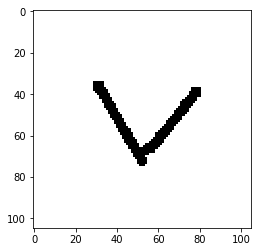

In [6]:
plt.imshow(batch[0, 3, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [7]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/vb-omniglot-simple-B2-S0.00_1


In [8]:
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

tf.reset_default_graph()

inputs, train_init_op, test_init_op = get_data_iterator_from_generator(train_generator, input_dim, 
                                                                       A, P,K, n=NUM_BRANCHES)

(None, 105, 105, 1)
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
inputs

[<tf.Tensor 'input_1:0' shape=(?, 105, 105, 1) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(?, 105, 105, 1) dtype=float32>]

In [10]:
lr = tf.placeholder('float32', name='lr')
lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'res':
        model = ResNet18(inputs, OUTPUT_DIM, name=name, shared_frac=SHARED_FRAC)
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)

    # Compile model
    model.compile(optimizer, triplet_omniglot(A, P, K), train_init_op, test_init_op, 
                  callbacks={'acc': one_shot_acc(NUM_BRANCHES)}, 
                  schedulers={'lr:0': lr_scheduler})

model.summary()

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
i   Layer name                      Output shape       Num param  Inbound            
-------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                 
-------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                 
-------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,103,103,32]  640        input              
                                    [None,103,103,32]                                
-------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,103,103,32]  128        conv2d_1_1         
              

In [11]:
print(model.output)

[<tf.Tensor 'model/output/vb1/output:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model/output/vb2/output:0' shape=(?, 128) dtype=float32>]


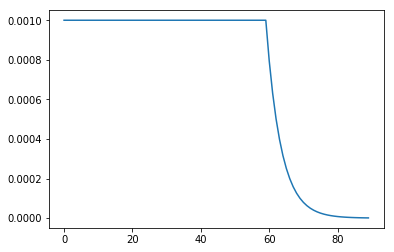

In [12]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [13]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, log_path=model_path if SAVE else None)

Epoch 1/90
 - 85s - lr:0: 0.0010 - loss_1: 969.4816 - loss_2: 911.6761 - acc_ensemble: 0.5550 - acc_2: 0.4900 - acc_1: 0.5100
Epoch 2/90


KeyboardInterrupt: 

## Evaluation

### Baseline

In [15]:
assert NUM_BRANCHES == 1

model_id_list = [1]
baseline_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc = baseline_one_shot(sess, model_name='model_'+str(model_id))
        print('Model {} acc:'.format(model_id), acc)
        baseline_acc_list.append(acc)
        
print('Mean acc:', np.mean(baseline_acc_list), ', std:', np.std(baseline_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/omniglot-res_1/ckpt
Model 1 acc: 0.8049999999999999
Mean acc: 0.8049999999999999 , std: 0.0


### Virtual Branching

In [8]:
model_id_list = [1]
vbranch_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(dataset, architecture,
                                            NUM_BRANCHES, SHARED_FRAC, model_id)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)    
        acc, branch_acc = vbranch_one_shot(sess, model_name='model_'+str(model_id), 
                                           n_branches=NUM_BRANCHES)
        print('Model {} acc:'.format(model_id), acc, branch_acc)
        vbranch_acc_list.append(acc)
        
print('Mean acc:', np.mean(vbranch_acc_list), ', std:', np.std(vbranch_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/vb-omniglot-res-B2-S0.25_1/ckpt
Model 1 acc: 0.8375 [0.7849999999999999, 0.8125]
Mean acc: 0.8375 , std: 0.0
